In [1]:
#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'modelproject'))
	print(os.getcwd())
except:
	pass

/Users/thomasmidjord/Desktop/KU Polit/8. semester/Introduction To Programming And Numerical Analysis/Workflow/projects-2019-tm-and-mp/modelproject/modelproject


Imports and set magics:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import linalg
from scipy import optimize
import sympy as sm

# To print nicely:
sm.init_printing(use_unicode=True)

# autoreload modules when code is run
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The basic Solow model

The basic Solow model is as follows:

$$ Y_t = AK_t^{\alpha}L_t^{1-\alpha} $$

$$ r_t = \alpha A \left(\frac{K_t}{L_t}\right)^{\alpha-1} $$

$$ w_t = (1-\alpha) A \left(\frac{K_t}{L_t}\right)^{\alpha-1} $$
 
$$ S_t = sY_t $$

$$ K_{t+1} - K_t = S_t -\delta K_t $$

$$ L_{t+1} = (1-n)L_t $$

We also define the following equations:

$$ y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} $$

$$ k_t = \frac{K_t}{L_t} $$

## Defining symbols

First we define the necessary variables so we can use sympy:

In [21]:
Y = sm.symbols("Y_t")
y = sm.symbols("y_t")
K = sm.symbols("K_t")
k = sm.symbols("k_t")
r = sm.symbols("r_t")
w = sm.symbols("w_t")
s = sm.symbols("s")
n = sm.symbols("n")
g = sm.symbols("g")
A = sm.symbols("A")
L = sm.symbols("L_t")
alpha = sm.symbols("alpha")
delta = sm.symbols("delta")
kstar = sm.symbols("k_t^*")
ystar = sm.symbols("y^*")

## Solving for steady state

We find the steady state by solving the equation $k_{t+1}-k_t = \frac{1}{1+n} (sAk_t^{\alpha} -(n+\delta)k_t)$ for the constant solution where $k_{t+1} = k_t = k^*$. This gives us the equation $sAk^{\alpha} - (n-\delta)k = 0$ to solve.

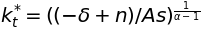

In [22]:
ksteady = sm.solve(s*A*k**alpha-(n-delta)*k, k)[0]
sm.Eq(kstar , ksteady)

This helps us solving for $y^*$:

In [23]:
eq1 = sm.simplify(A*ksteady**alpha)
sm.Eq(ystar, eq1)

## Simulating the basic Solow model

In [24]:
def simulate_basic(k,alpha,delta,s,n,A,T):
    """
    Args:
    k (int): initial value for physical capital per worker
    alpha (float): return on physical capital
    delta (float): depreciation rate
    s (float): investments
    n (float): increase in labour
    A (int): totalfactorproductivity
    T (int): periods to simulate through
    
    Returns:
    A plot showing how capital per worker accumulates over time"""
    
    #First we make a list for our future values to be in
    k_path = [k]
    
    #Then we make which will contain the values for the 45-degree-line
    Degreeline = [0]
    
    #We generate the 45-degree-line for the basic Solow model
    for t in range(1,T):
        line = (n + delta)*t
        Degreeline.append(line)
        
    #We generate the Solow movement
    for t in range(1,T):
        k_plus = s*A*t**alpha
        k_path.append(k_plus)
    
    #Plotting the stuff
    plt.figure(figsize=(5,5))
    plt.plot(k_path[:T], label='$sAk_t^{\u03B1}$')
    plt.plot(Degreeline[:T], label = '$(n+\delta)k_t$')
    plt.xlim(0,T)
    plt.ylim(0,Degreeline[-1])
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    
    return plt.show()

Example on a simulation with reasonable values:

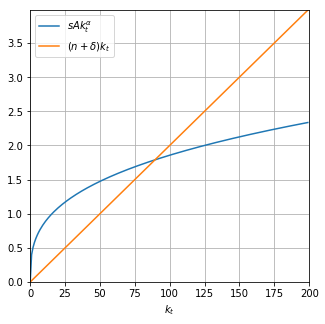

In [25]:
simulate_basic(0,1/3,0.01,0.4,0.01,1,200)

Below, you can try changing the parametres yourself to see how they influence the steady state.

In [26]:
widgets.interact(simulate_basic, 
                k = widgets.fixed(0), 
                alpha = widgets.FloatSlider(description = '$\u03B1$' , min = 0 , max = 0.9 , step = 0.05 , value = 0.3),
                delta = widgets.FloatSlider(description = '$\u03B4$' , min = 0 , max = 0.1 , step = 0.01 , value = 0.01),
                s = widgets.FloatSlider(description = 's' , min = 0.01 , max = 0.8 , step = 0.05 , value = 0.4),
                n = widgets.FloatSlider(description ='$n$', min = 0.01 , max = 0.1 , step = 0.005, value = 0.01),
                A = widgets.fixed(1),
                T = widgets.IntSlider(description='$T$' , min = 1, max = 1000, step = 10, value = 100))

interactive(children=(FloatSlider(value=0.3, description='$α$', max=0.9, step=0.05), FloatSlider(value=0.01, d…

<function __main__.simulate_basic(k, alpha, delta, s, n, A, T)>

# The Solow-model with land

The Solow-model with land is as follows:

$$ Y_t = K_t^{\alpha}(A_tL_t)^{\beta}X^{\kappa}, \quad \alpha + \beta + \kappa = 1. $$

$$ K_{t+1} = sY_t+(1-\delta)K_t, \quad K_0 \text{ given}. $$

$$ L_{t+1} = (1+n)L_t, \quad n≥0, \quad L_0 \text{ given}. $$

$$ A_{t+1} = (1+g)A_t, \quad g≥0, \quad A_0 \text{ given}. $$

$$ r_t = \alpha \left(\frac{K_t}{A_t L_t}\right)^{\alpha-1} \left(\frac{X}{A_t L_t}\right)^\kappa $$

$$ w_t = \beta \left(\frac{K_t}{A_t L_t}\right)^{\alpha} \left(\frac{X}{A_t L_t}\right)^\kappa A_t $$

$$ v_t = \kappa \left(\frac{K_t}{A_t L_t}\right)^{\alpha} \left(\frac{X}{A_t L_t}\right)^{\kappa-1} $$

* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$)
* $A_t$ is technology (growing with a constant rate of $g$)
* $X$ is land (constant)
<br> <br>
* $s$ is the savings rate (which is assumed to be constant)
* $r_t$ is the return to capital
* $w_t$ is the wage rate
* $v_t$ is the return to land

**Saving** is a constant fraction of GDP
$$ S_t = sY_t,\,s\in(0,1) $$
Defining the following variables:

$$ \text{Capital-output ratio:} \quad z_t=\frac{K_t}{Y_t} $$

$$ \text{Capital per worker:} \quad k_t=\frac{K_t}{L_t} $$

$$ \text{Land per worker:} \quad x_t=\frac{X_t}{L_t} $$

$$ \text{Output per worker:} \quad y_t=\frac{Y_t}{L_t} $$

$$ y_t = k_t^\alpha A_t^\beta x_t^\kappa $$

# Steady state

## Analytical solution

First we define all necessary **symbols** so we can use sympy:

In [27]:
z = sm.symbols('z_t')
v = sm.symbols('v_t')
beta = sm.symbols('beta')
kappa = sm.symbols('kappa')
zc = sm.symbols('z')
zstar = sm.symbols('z^*')
landpc = sm.symbols('x_t')

We are working with the transition equation for the capital-output ratio (z)

$$ z_{t+1} = \left(\frac{1}{(1+n)(1+g)}\right)^\beta [(s+(1-\delta)z_t)]^{1-\alpha} z_t^\alpha $$

Solving for z to find z*

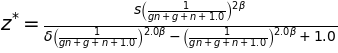

In [29]:
# Choosing value for alpha in order to be able to use sympy.solve function
alpha = 0.5

# Calculating the the chose value for alpha
z_eq = sm.Eq(zc, (1/((1+n)*(1+g)))**beta * (s+(1-delta)*zc)**(1-alpha)*zc**alpha)
z_eq
z_solve = sm.simplify(sm.solve(z_eq, zc)[1])
zfinal = sm.Eq(zstar, z_solve)
zfinal

$z^*$ can also be reduced to the following for a given $\alpha$ value

$$ z^* = \frac{s}{[(1+n)(1+g)]^{\frac{\beta}{1-\alpha}}-(1-\delta)} $$

We are finding $y^*$ by using the formula for $y_t$ we defined earlier:

$$ y_t = k_t^\alpha A_t^\beta x_t^\kappa $$

We devide by $y_t^\alpha$ and find:

$$ y_t^{1-\alpha} = z_t^\alpha A_t^\beta x_t^\kappa $$

Isolating $y_t$ and inserting $z^*$ gives us $y_t^*$:

$$ y_t^* = (z^*)^{\frac{\alpha}{\beta+\kappa}} A_t^{\frac{\beta}{\beta+\kappa}} x_t^{\frac{\kappa}{\beta+\kappa}} $$

Using the growth rates of technology and labor we can rewrite this as:

$$ y_t^* = (z^*)^{\frac{\alpha}{\beta+\kappa}} A_0^{\frac{\beta}{\beta+\kappa}} \left(\frac{X}{L_o}\right)^{\frac{\kappa}{\beta+\kappa}} (1+g)^{\frac{\beta}{\beta+\kappa}t} (1+n)^{-\frac{\kappa}{\beta+\kappa}t} $$